<font size="5"><center> **Exercise 1.a <br>
(DCGAN with original loss function on Fashion MNIST dataset.)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [2]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-9

In [3]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

<font size = '3'>The following notebook is based entirely on Tutorial 10 of this DCGAN course. The main changes include using the FashionMNIST dataset instead of MNIST and modifications to the architecture of the Generator and Discriminator as outlined in the previous question (1.a).

<font size = '3'> 

- Generator Class: generator model with one dense layer followed by three convolutional layers. The generator takes a noise vector (latent space input) and transforms it into a 28x28 image. <br>
- Discriminator Network: discriminator model with three convolutional layers followed by one dense layer. It takes an image as input and outputs a single scalar value representing the probability of the input image being real or fake. 

↓ Generator / Discriminator ↓

In [4]:
class Generator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()

        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape

        self.model = nn.Sequential(
            nn.Linear(self.noise_dim, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.PReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise.view(-1, self.noise_dim))

class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()

        self.data_shape = input_shape

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(128*3*3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(-1, *self.data_shape))

<font size = '3'>

- `Weight Initialization` function for the weights of the model to ensure proper convergence during training.
- `generate` function for generation and display of samples from the generator model.
- `plot_loss` function, that plots the loss curves for both the generator and the discriminator over the epochs.
- `load_and_generate` function that loads a pre-trained generator model from a saved file and generates images. It also plots the loss curves.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def generate(n_samples, title, gen, noise_dim, device):
    z = tc.randn(n_samples, noise_dim, device=device)
    x_hat = gen(z).detach().cpu().numpy()

    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i].reshape(28, 28), cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

def plot_loss(d_loss, g_loss, epochs):

    epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(epoch_ax, d_loss, color='blue')
    ax[0].set_xlim(1, epochs)
    ax[0].set_title("Discriminator Loss vs Epoch")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Discriminator Loss")
    ax[0].grid(alpha=0.45)

    ax[1].plot(epoch_ax, g_loss, color='red')
    ax[1].set_xlim(1, epochs)
    ax[1].set_title("Generator Loss vs Epoch")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Generator Loss")
    ax[1].grid(alpha=0.45)

    plt.tight_layout()
    plt.show()
    plt.close()

# Function to load the best generator model and generate images
def load_and_generate(filename, n_samples, data_shape, noise_dim, device):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    epoch = int(data['all_epochs'])    
    best_epoch = int(data['best_epoch'])
    d_loss = data['disc_losses']
    g_loss = data['gen_losses']
    

    title= f"Generated Images for Best Model - Epoch: {best_epoch+1}"
    gen = Generator(input_shape=data_shape, noise_shape=noise_dim).to(device)
    gen.load_state_dict(data['model_state_dict'])
    gen.eval()   
    
    generate(n_samples, title, gen, noise_dim, device)
    plot_loss(d_loss, g_loss, epoch)

The below `training loop` function performs the training loop for the GAN. It trains the discriminator and the generator in alternating steps, applying the BCE loss function, and saving the best generator model based on the generator loss. It also periodically generates samples during training and saves the model checkpoints.

↓ Train Loop ↓

In [6]:
def train_loop(gen, disc, opt_disc, opt_gen, train_loader, noise_dim,
               n_samples, epochs, sample_every, check_path, device):
    
    loss_fn = nn.BCELoss()

    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    gen.train()
    disc.train()

    best_gen_loss = float('inf')
    best_epoch = 0

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            opt_disc.zero_grad()
            x = x.to(device)
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            target_fake = tc.zeros((x.shape[0], 1)).to(device)
            pred_real = disc(x)
            pred_fake = disc(x_hat)

            loss_real = loss_fn(pred_real, target_real)
            loss_fake = loss_fn(pred_fake, target_fake)
            loss_disc = (loss_real + loss_fake) / 2
            disc_loss += loss_disc.item()

            loss_disc.backward()
            opt_disc.step()

            # ------------------------ Train Generator: ------------------------
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            pred_fake = disc(x_hat)

            loss_gen = loss_fn(pred_fake, target_real)
            gen_loss += loss_gen.item()

            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        
        # Save the best generator model
        if gen_losses[epoch] < best_gen_loss:
            best_gen_loss = gen_losses[epoch]
            best_gen_model = gen.state_dict()
            best_epoch = epoch  
        
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(n_samples, f"Epoch {epoch + 1}", gen, noise_dim, device)
            gen.train()
    
    # Save the best generator model and losses to disk
    save_data = {
        'model_state_dict': best_gen_model,
        'best_epoch': best_epoch,
        'all_epochs': epochs,
        'disc_losses': disc_losses,
        'gen_losses': gen_losses
    }
    with open(check_path, 'wb') as f:
        pickle.dump(save_data, f)

    return disc_losses, gen_losses

Using --> cuda


100%|██████████| 469/469 [00:16<00:00, 29.15it/s]


Epoch [1/100] | Loss D: 0.5668 | Loss G: 1.0301


100%|██████████| 469/469 [00:21<00:00, 21.50it/s]


Epoch [2/100] | Loss D: 0.5558 | Loss G: 1.0567


100%|██████████| 469/469 [00:22<00:00, 20.67it/s]


Epoch [3/100] | Loss D: 0.5950 | Loss G: 0.9244


100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Epoch [4/100] | Loss D: 0.5908 | Loss G: 0.9313


100%|██████████| 469/469 [00:23<00:00, 20.34it/s]


Epoch [5/100] | Loss D: 0.5866 | Loss G: 0.9407


100%|██████████| 469/469 [00:24<00:00, 19.43it/s]


Epoch [6/100] | Loss D: 0.5782 | Loss G: 0.9538


100%|██████████| 469/469 [00:24<00:00, 19.24it/s]


Epoch [7/100] | Loss D: 0.5707 | Loss G: 0.9814


100%|██████████| 469/469 [00:21<00:00, 21.37it/s]


Epoch [8/100] | Loss D: 0.5550 | Loss G: 1.0143


100%|██████████| 469/469 [00:24<00:00, 19.32it/s]


Epoch [9/100] | Loss D: 0.5428 | Loss G: 1.0375


100%|██████████| 469/469 [00:23<00:00, 20.10it/s]


Epoch [10/100] | Loss D: 0.5269 | Loss G: 1.0737


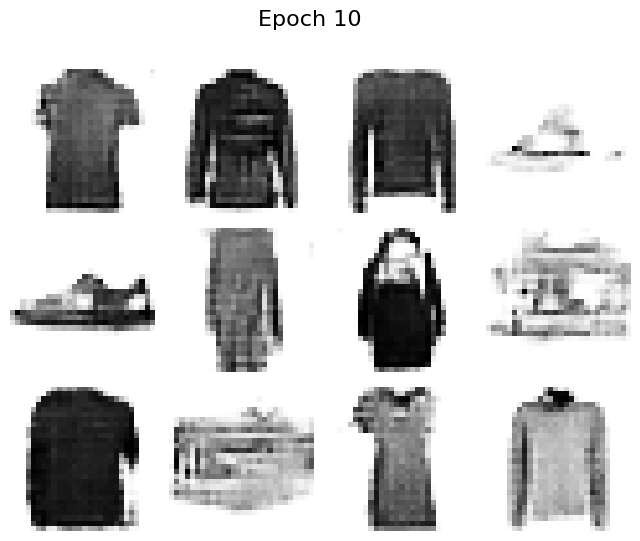

100%|██████████| 469/469 [00:22<00:00, 20.66it/s]


Epoch [11/100] | Loss D: 0.5208 | Loss G: 1.1062


100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Epoch [12/100] | Loss D: 0.5154 | Loss G: 1.1206


100%|██████████| 469/469 [00:23<00:00, 19.57it/s]


Epoch [13/100] | Loss D: 0.5018 | Loss G: 1.1507


100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Epoch [14/100] | Loss D: 0.4911 | Loss G: 1.1808


100%|██████████| 469/469 [00:22<00:00, 20.80it/s]


Epoch [15/100] | Loss D: 0.4869 | Loss G: 1.2013


100%|██████████| 469/469 [00:24<00:00, 19.41it/s]


Epoch [16/100] | Loss D: 0.4732 | Loss G: 1.2361


100%|██████████| 469/469 [00:24<00:00, 19.37it/s]


Epoch [17/100] | Loss D: 0.4623 | Loss G: 1.2665


100%|██████████| 469/469 [00:24<00:00, 19.40it/s]


Epoch [18/100] | Loss D: 0.4585 | Loss G: 1.2887


100%|██████████| 469/469 [00:22<00:00, 20.80it/s]


Epoch [19/100] | Loss D: 0.4480 | Loss G: 1.3052


100%|██████████| 469/469 [00:23<00:00, 20.36it/s]


Epoch [20/100] | Loss D: 0.4398 | Loss G: 1.3234


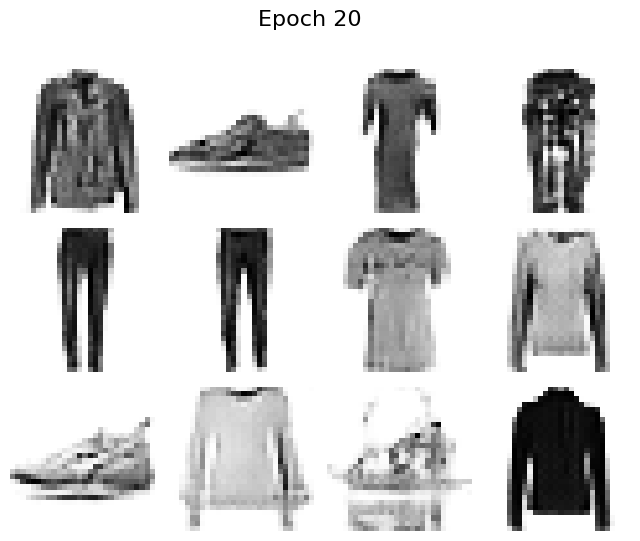

100%|██████████| 469/469 [00:23<00:00, 19.95it/s]


Epoch [21/100] | Loss D: 0.4326 | Loss G: 1.3609


100%|██████████| 469/469 [00:24<00:00, 19.41it/s]


Epoch [22/100] | Loss D: 0.4240 | Loss G: 1.3898


100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Epoch [23/100] | Loss D: 0.4151 | Loss G: 1.3981


100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


Epoch [24/100] | Loss D: 0.4080 | Loss G: 1.4239


100%|██████████| 469/469 [00:22<00:00, 21.24it/s]


Epoch [25/100] | Loss D: 0.4025 | Loss G: 1.4503


100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Epoch [26/100] | Loss D: 0.3966 | Loss G: 1.4738


100%|██████████| 469/469 [00:23<00:00, 20.04it/s]


Epoch [27/100] | Loss D: 0.3874 | Loss G: 1.4965


100%|██████████| 469/469 [00:23<00:00, 19.88it/s]


Epoch [28/100] | Loss D: 0.3824 | Loss G: 1.5026


100%|██████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch [29/100] | Loss D: 0.3782 | Loss G: 1.5365


100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Epoch [30/100] | Loss D: 0.3735 | Loss G: 1.5526


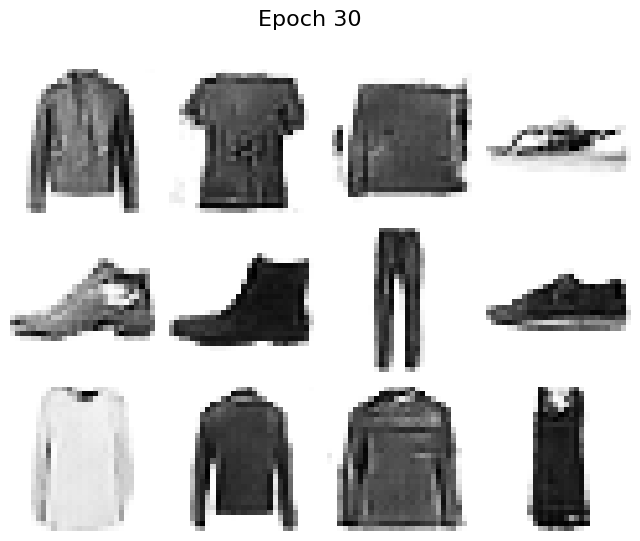

100%|██████████| 469/469 [00:21<00:00, 21.39it/s]


Epoch [31/100] | Loss D: 0.3675 | Loss G: 1.5871


100%|██████████| 469/469 [00:21<00:00, 21.50it/s]


Epoch [32/100] | Loss D: 0.3614 | Loss G: 1.6014


100%|██████████| 469/469 [00:22<00:00, 21.23it/s]


Epoch [33/100] | Loss D: 0.3530 | Loss G: 1.6284


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Epoch [34/100] | Loss D: 0.3455 | Loss G: 1.6282


100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Epoch [35/100] | Loss D: 0.3422 | Loss G: 1.6685


100%|██████████| 469/469 [00:23<00:00, 19.56it/s]


Epoch [36/100] | Loss D: 0.3355 | Loss G: 1.6643


100%|██████████| 469/469 [00:25<00:00, 18.76it/s]


Epoch [37/100] | Loss D: 0.3274 | Loss G: 1.6912


100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Epoch [38/100] | Loss D: 0.3238 | Loss G: 1.7179


100%|██████████| 469/469 [00:24<00:00, 19.21it/s]


Epoch [39/100] | Loss D: 0.3176 | Loss G: 1.7525


100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Epoch [40/100] | Loss D: 0.3205 | Loss G: 1.7437


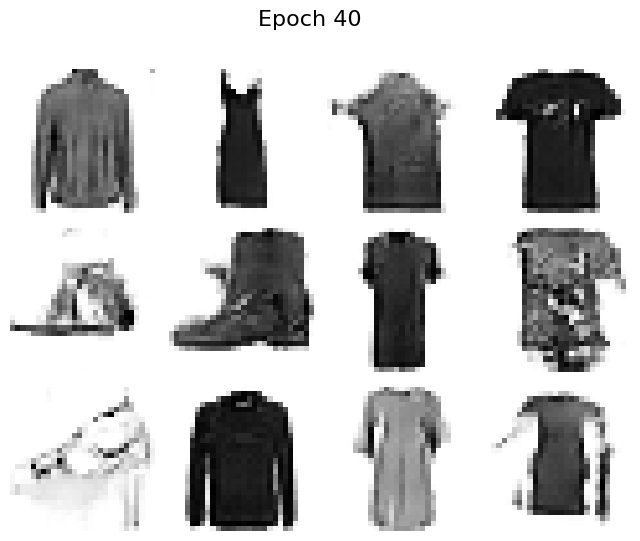

100%|██████████| 469/469 [00:25<00:00, 18.16it/s]


Epoch [41/100] | Loss D: 0.3114 | Loss G: 1.7573


100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


Epoch [42/100] | Loss D: 0.3031 | Loss G: 1.7914


100%|██████████| 469/469 [00:25<00:00, 18.48it/s]


Epoch [43/100] | Loss D: 0.3000 | Loss G: 1.7906


100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


Epoch [44/100] | Loss D: 0.2957 | Loss G: 1.8379


100%|██████████| 469/469 [00:24<00:00, 18.87it/s]


Epoch [45/100] | Loss D: 0.2900 | Loss G: 1.8568


100%|██████████| 469/469 [00:24<00:00, 19.15it/s]


Epoch [46/100] | Loss D: 0.2909 | Loss G: 1.8702


100%|██████████| 469/469 [00:24<00:00, 19.53it/s]


Epoch [47/100] | Loss D: 0.2838 | Loss G: 1.8496


100%|██████████| 469/469 [00:27<00:00, 17.22it/s]


Epoch [48/100] | Loss D: 0.2842 | Loss G: 1.8961


100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Epoch [49/100] | Loss D: 0.2795 | Loss G: 1.9172


100%|██████████| 469/469 [00:25<00:00, 18.65it/s]


Epoch [50/100] | Loss D: 0.2722 | Loss G: 1.9617


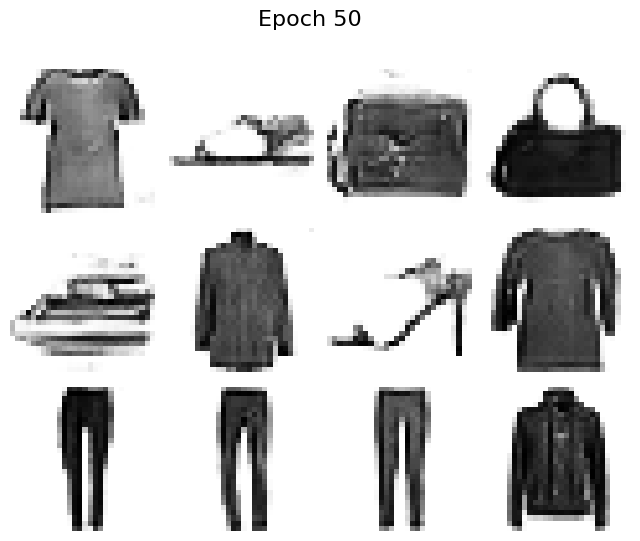

100%|██████████| 469/469 [00:23<00:00, 19.57it/s]


Epoch [51/100] | Loss D: 0.2764 | Loss G: 1.9530


100%|██████████| 469/469 [00:25<00:00, 18.71it/s]


Epoch [52/100] | Loss D: 0.2651 | Loss G: 1.9763


100%|██████████| 469/469 [00:23<00:00, 19.68it/s]


Epoch [53/100] | Loss D: 0.2695 | Loss G: 2.0062


100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Epoch [54/100] | Loss D: 0.2581 | Loss G: 1.9638


100%|██████████| 469/469 [00:24<00:00, 19.52it/s]


Epoch [55/100] | Loss D: 0.2570 | Loss G: 1.9881


100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


Epoch [56/100] | Loss D: 0.2453 | Loss G: 2.0126


100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


Epoch [57/100] | Loss D: 0.2467 | Loss G: 2.0383


100%|██████████| 469/469 [00:22<00:00, 20.78it/s]


Epoch [58/100] | Loss D: 0.2335 | Loss G: 2.0832


100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch [59/100] | Loss D: 0.2397 | Loss G: 2.0910


100%|██████████| 469/469 [00:23<00:00, 20.19it/s]


Epoch [60/100] | Loss D: 0.2243 | Loss G: 2.0888


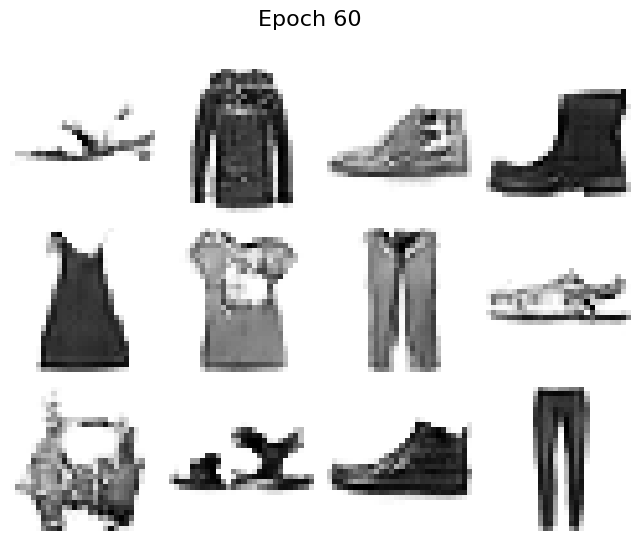

100%|██████████| 469/469 [00:24<00:00, 19.05it/s]


Epoch [61/100] | Loss D: 0.2338 | Loss G: 2.1024


100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


Epoch [62/100] | Loss D: 0.2328 | Loss G: 2.1491


100%|██████████| 469/469 [00:24<00:00, 18.77it/s]


Epoch [63/100] | Loss D: 0.2236 | Loss G: 2.1826


100%|██████████| 469/469 [00:25<00:00, 18.63it/s]


Epoch [64/100] | Loss D: 0.2236 | Loss G: 2.2076


100%|██████████| 469/469 [00:25<00:00, 18.65it/s]


Epoch [65/100] | Loss D: 0.2167 | Loss G: 2.1309


100%|██████████| 469/469 [00:23<00:00, 19.61it/s]


Epoch [66/100] | Loss D: 0.2134 | Loss G: 2.1664


100%|██████████| 469/469 [00:24<00:00, 19.15it/s]


Epoch [67/100] | Loss D: 0.2250 | Loss G: 2.1688


100%|██████████| 469/469 [00:24<00:00, 19.28it/s]


Epoch [68/100] | Loss D: 0.2188 | Loss G: 2.1988


100%|██████████| 469/469 [00:23<00:00, 19.75it/s]


Epoch [69/100] | Loss D: 0.2050 | Loss G: 2.2183


100%|██████████| 469/469 [00:19<00:00, 24.61it/s]


Epoch [70/100] | Loss D: 0.2058 | Loss G: 2.2334


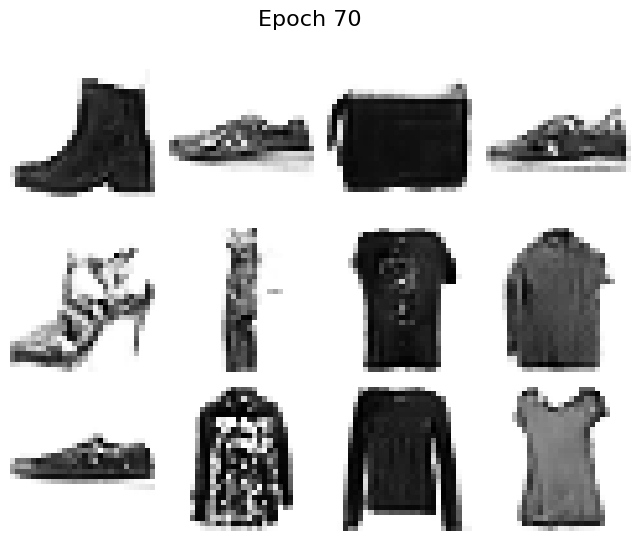

100%|██████████| 469/469 [00:23<00:00, 19.88it/s]


Epoch [71/100] | Loss D: 0.2086 | Loss G: 2.2874


100%|██████████| 469/469 [00:23<00:00, 19.75it/s]


Epoch [72/100] | Loss D: 0.2101 | Loss G: 2.2997


100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Epoch [73/100] | Loss D: 0.2069 | Loss G: 2.3004


100%|██████████| 469/469 [00:23<00:00, 20.06it/s]


Epoch [74/100] | Loss D: 0.2015 | Loss G: 2.3200


100%|██████████| 469/469 [00:22<00:00, 20.74it/s]


Epoch [75/100] | Loss D: 0.1929 | Loss G: 2.2954


100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Epoch [76/100] | Loss D: 0.2047 | Loss G: 2.3350


100%|██████████| 469/469 [00:23<00:00, 20.34it/s]


Epoch [77/100] | Loss D: 0.1939 | Loss G: 2.3336


100%|██████████| 469/469 [00:23<00:00, 19.62it/s]


Epoch [78/100] | Loss D: 0.1855 | Loss G: 2.3124


100%|██████████| 469/469 [00:23<00:00, 19.61it/s]


Epoch [79/100] | Loss D: 0.1972 | Loss G: 2.3748


100%|██████████| 469/469 [00:23<00:00, 20.38it/s]


Epoch [80/100] | Loss D: 0.1915 | Loss G: 2.3675


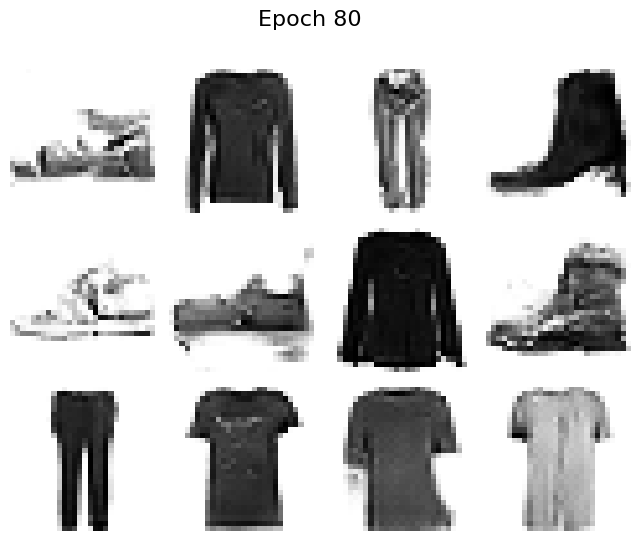

100%|██████████| 469/469 [00:23<00:00, 20.39it/s]


Epoch [81/100] | Loss D: 0.1894 | Loss G: 2.3839


100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Epoch [82/100] | Loss D: 0.1871 | Loss G: 2.3119


100%|██████████| 469/469 [00:23<00:00, 20.06it/s]


Epoch [83/100] | Loss D: 0.1895 | Loss G: 2.3320


100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Epoch [84/100] | Loss D: 0.1825 | Loss G: 2.3899


100%|██████████| 469/469 [00:23<00:00, 19.79it/s]


Epoch [85/100] | Loss D: 0.1764 | Loss G: 2.4162


100%|██████████| 469/469 [00:23<00:00, 19.75it/s]


Epoch [86/100] | Loss D: 0.1770 | Loss G: 2.4432


100%|██████████| 469/469 [00:23<00:00, 19.65it/s]


Epoch [87/100] | Loss D: 0.1729 | Loss G: 2.4752


100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Epoch [88/100] | Loss D: 0.1800 | Loss G: 2.4693


100%|██████████| 469/469 [00:23<00:00, 20.37it/s]


Epoch [89/100] | Loss D: 0.1727 | Loss G: 2.4250


100%|██████████| 469/469 [00:23<00:00, 20.31it/s]


Epoch [90/100] | Loss D: 0.1855 | Loss G: 2.5119


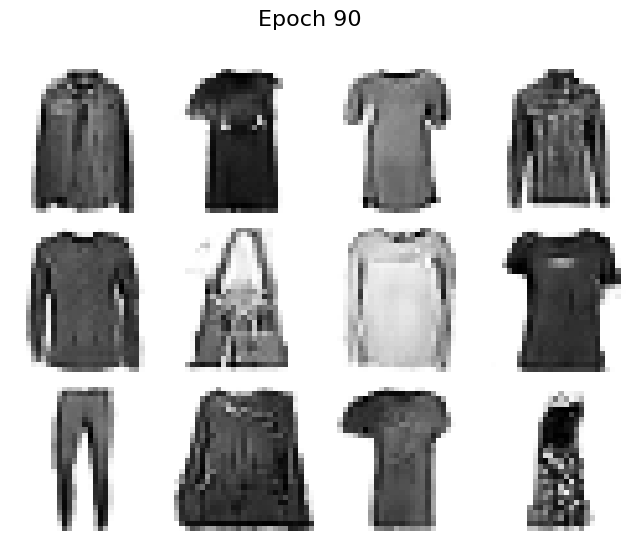

100%|██████████| 469/469 [00:24<00:00, 19.47it/s]


Epoch [91/100] | Loss D: 0.1704 | Loss G: 2.4836


100%|██████████| 469/469 [00:24<00:00, 18.77it/s]


Epoch [92/100] | Loss D: 0.1580 | Loss G: 2.5052


100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch [93/100] | Loss D: 0.1646 | Loss G: 2.5445


100%|██████████| 469/469 [00:23<00:00, 20.05it/s]


Epoch [94/100] | Loss D: 0.1695 | Loss G: 2.5936


100%|██████████| 469/469 [00:23<00:00, 19.91it/s]


Epoch [95/100] | Loss D: 0.1662 | Loss G: 2.5416


100%|██████████| 469/469 [00:22<00:00, 20.71it/s]


Epoch [96/100] | Loss D: 0.1679 | Loss G: 2.5479


100%|██████████| 469/469 [00:24<00:00, 19.45it/s]


Epoch [97/100] | Loss D: 0.1700 | Loss G: 2.4984


100%|██████████| 469/469 [00:23<00:00, 19.85it/s]


Epoch [98/100] | Loss D: 0.1545 | Loss G: 2.6451


100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Epoch [99/100] | Loss D: 0.1695 | Loss G: 2.5945


100%|██████████| 469/469 [00:23<00:00, 19.97it/s]


Epoch [100/100] | Loss D: 0.1551 | Loss G: 2.6233


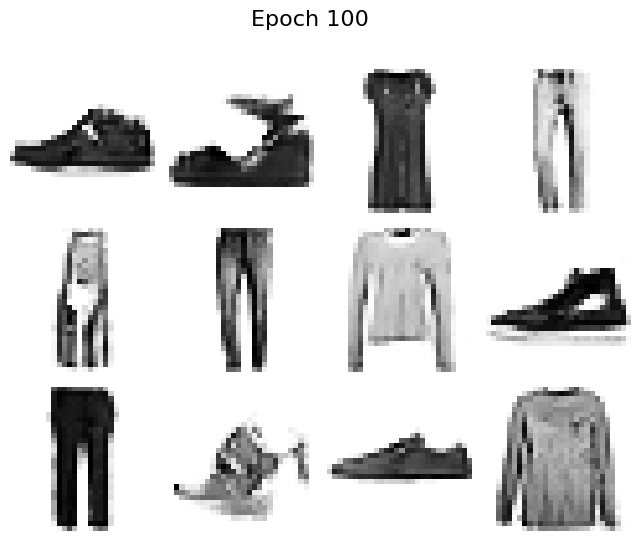

In [8]:
# Train the WGAN for a number of epochs in order to generate images.
# RUN this cell only if you want to train the model.
# If you want to generate images based on .pkl checkpoint, DON'T RUN this 
# training cell and the below cell that plots the losses.

# Main
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using --> {device}")

batch_size = 128
lr = 2e-4
betas = (0.5, 0.999)

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

data_shape = (1, 28, 28)
noise_dim = 100

# Create GENERATOR Object
gen = Generator(input_shape=data_shape, noise_shape=noise_dim).to(device)
gen.apply(weights_init)
opt_gen = Adam(params=gen.parameters(), lr=lr, betas=betas)

# Create DISCRIMINATOR Object
disc = Discriminator(input_shape=data_shape).to(device)
disc.apply(weights_init)
opt_disc = Adam(params=disc.parameters(), lr=lr, betas=betas)

# Initialize for the training
check_path = 'checkpoints/best_DCGAN.pkl'
epochs = 100
n_samples = 12
sample_every = 10 

d_loss, g_loss = train_loop(gen, disc, opt_disc, opt_gen, train_loader, noise_dim,
                            n_samples, epochs, sample_every, check_path, device)

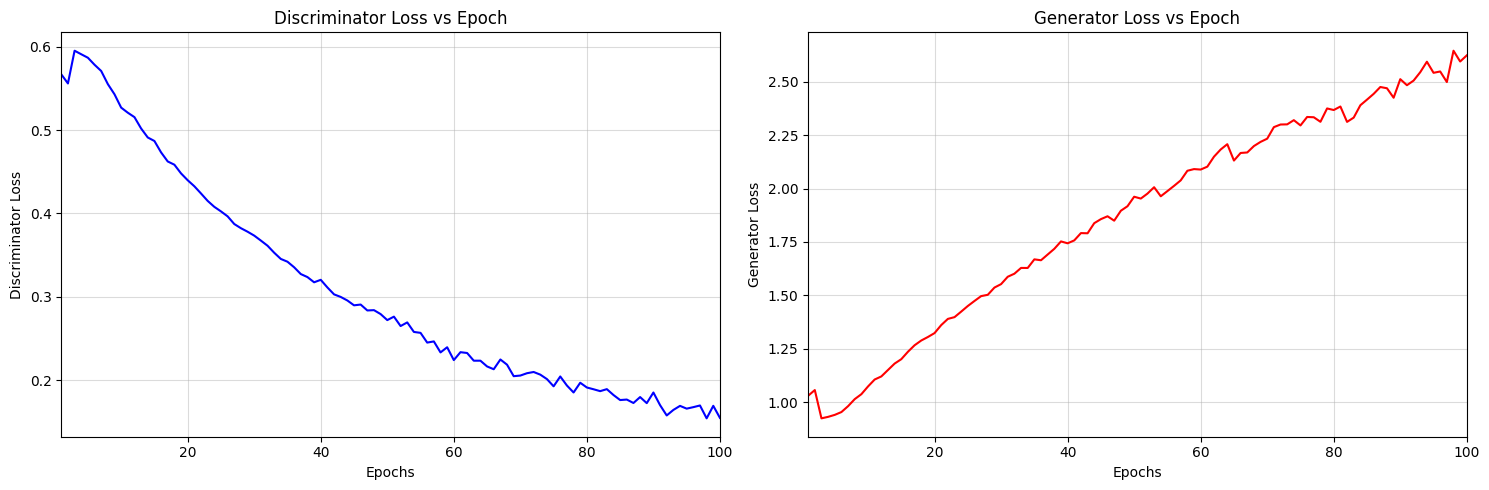

In [9]:
# Plot the DIscriminator and Generator Loss over Epochs

plot_loss(d_loss, g_loss, epochs)

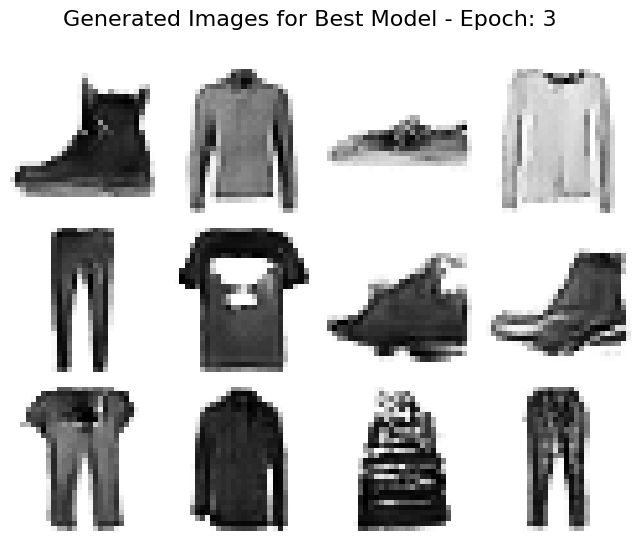

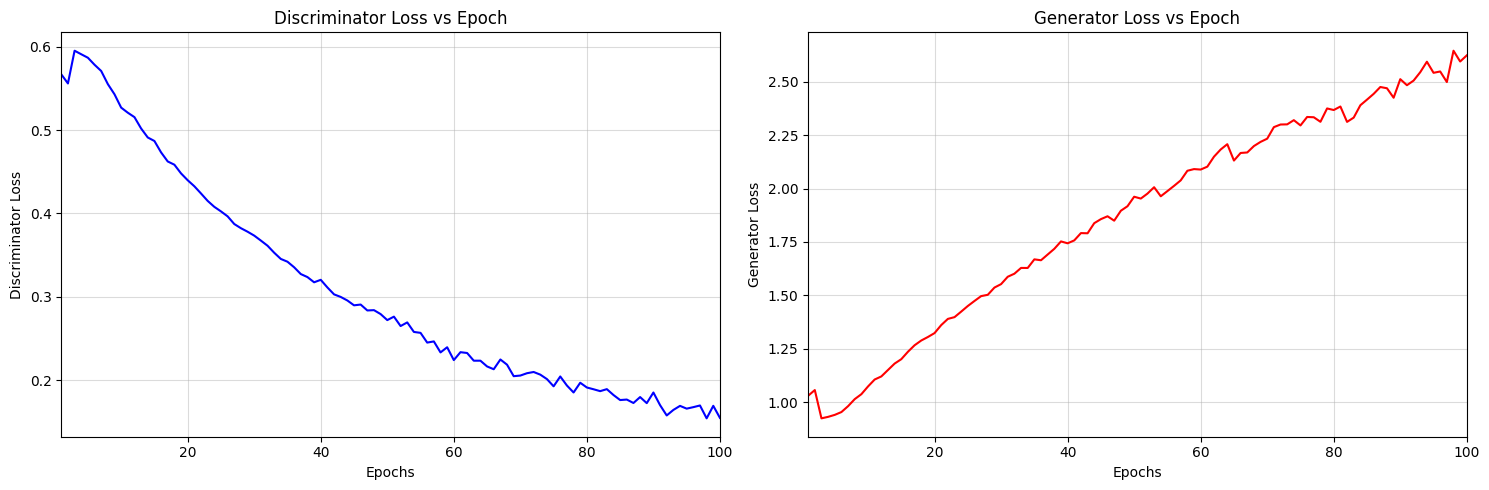

In [14]:
# LOAD AND GENERATE IMAGES based on the best Model of training
# IF YOU ONLY want to generate images and loss plots based on the 
# best trained model RUN all the cell EXCEPT the ABOVE TWO (training & plots) ↑

seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'

data_shape = (1, 28, 28)
noise_dim = 100

# Initialize for the training
check_path = 'checkpoints/best_DCGAN.pkl'
n_samples = 12

load_and_generate(check_path, n_samples, data_shape, noise_dim, device)